# GAN Vanilla Architecture (No attention) 

In this notebook, we explore simple GANs to generate realistic images of cars

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle
import os
from pathlib import Path

from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.optimizers import Adam

# 1. Fetch Data

In [71]:
cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_masks.pickle')
cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_original.pickle')

In [72]:
with open(cars_mask_path, 'rb') as file:
    X_mask = pickle.load(file)
    
print(X_mask.shape)

(16185, 3, 64, 64)


In [73]:
with open(cars_original_path, 'rb') as file:
    X_original = pickle.load(file)
    
print(X_original.shape)

(16185, 3, 64, 64)


# 2.1 Simple Dense Architecture

In [74]:
n_train = 300

def load_data():
    X_train, X_test = X_original[:n_train], X_original[n_train:]
    X_train = X_train.transpose((0, 2, 3, 1))
    X_test = X_test.transpose((0, 2, 3, 1))
    X_train = X_train[:, :, :, 0]
    X_train = X_train.reshape(X_train.shape[0], -1)
    return (X_train, X_test)

(X_train, X_test) = load_data()
print(X_train.shape)

(300, 4096)


In [75]:
def create_generator():
    generator=Sequential()
    
    generator.add(Dense(units=256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=4096, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return generator

g = create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_133 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_134 (Dense)            (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_135 (Dense)            (None, 4096)              4198400   
Total para

In [76]:
def create_discriminator():
    discriminator=Sequential()
    
    discriminator.add(Dense(units=1024,input_dim=4096))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return discriminator

d = create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 1024)              4195328   
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 256)               131328    
__________

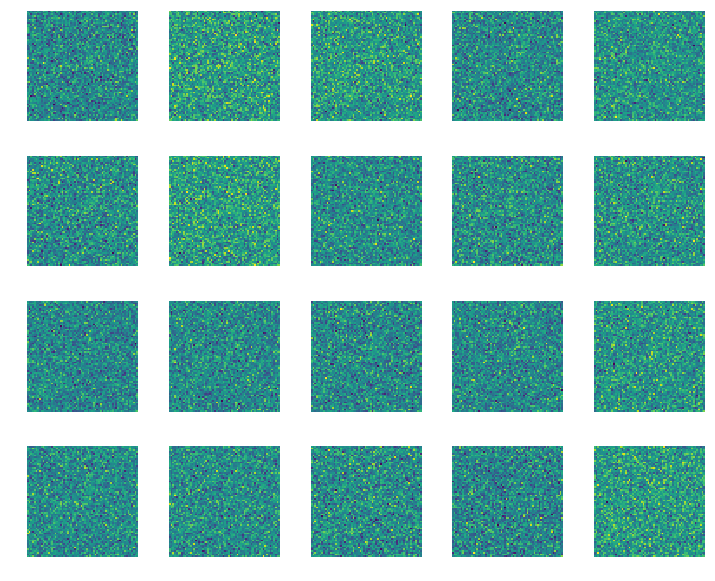

In [77]:
def plot_generated_images(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,64,64)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('figures/gan_generated_image %d.png' %epoch)
    
plot_generated_images(1, g, examples=20)

# 2.2 CNN based Architecture

In [ ]:
n_train = 100

def load_data():
    X_train, X_test = X_original[:n_train], X_original[n_train:]
    X_train = X_train.transpose((0, 2, 3, 1))
    X_test = X_test.transpose((0, 2, 3, 1))
    return (X_train, X_test)

(X_train, X_test) = load_data()
print(X_train.shape)

In [9]:
def create_generator():
    generator=Sequential()
    
    generator.add(Dense(units=16384, input_dim=100))
    generator.add(Reshape((4, 4, 1024)))
    
    generator.add(Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same'))
    generator.add(ReLU())
    
    generator.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
    generator.add(ReLU())
    
    generator.add(Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'))
    generator.add(ReLU())
    
    generator.add(Conv2DTranspose(filters=3, kernel_size=5, strides=2, padding='same', 
                                  activation=keras.activations.sigmoid))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
    return generator

g = create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         13107712  
_________________________________________________________________
re_lu_4 (ReLU)               (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 256)       3277056   
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 128)       819328    
__________

In [11]:
def create_discriminator():
    discriminator=Sequential()
    
    discriminator.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3, )))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(filters=256, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(filters=512, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
    return discriminator

d = create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 512)         3277312   
__________

In [34]:
def plot_generated_images(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,3,64,64)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].transpose(1, 2, 0), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('figures/gan_generated_image %d.png' %epoch)
    
#plot_generated_images(1, g, examples=20)

ValueError: cannot reshape array of size 81920 into shape (20,3,64,64)

# 2.3 MiniCNN based Architecture

In [57]:
n_train = 100

def load_data():
    X_train, X_test = X_original[:n_train], X_original[n_train:]
    X_train = X_train.transpose((0, 2, 3, 1))
    X_test = X_test.transpose((0, 2, 3, 1))
    return (X_train, X_test)

(X_train, X_test) = load_data()
print(X_train.shape)

(1, 64, 64, 3)


In [58]:
def create_generator():
    generator=Sequential()
    
    generator.add(Dense(units=16384, input_dim=100))
    generator.add(Reshape((8, 8, 256)))
    
    generator.add(Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'))
    generator.add(ReLU())
    
    generator.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
    generator.add(ReLU())
    
    generator.add(Conv2DTranspose(filters=3, kernel_size=5, strides=2, padding='same', 
                                  activation=keras.activations.sigmoid))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return generator

g = create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 16384)             1654784   
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 128)       819328    
_________________________________________________________________
re_lu_10 (ReLU)              (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 64)        204864    
_________________________________________________________________
re_lu_11 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 64, 64, 3)         4803      
Total para

In [59]:
def create_discriminator():
    discriminator=Sequential()
    
    discriminator.add(Conv2D(filters=32, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3, )))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return discriminator

d = create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
__________

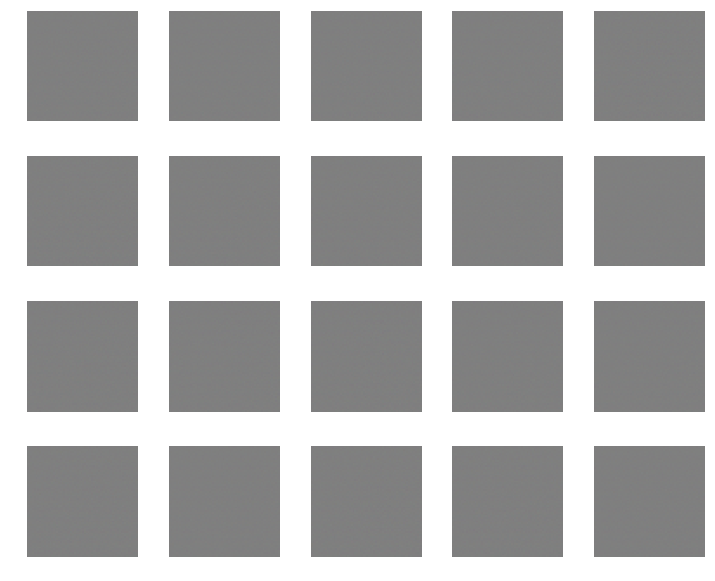

In [60]:
def plot_generated_images(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,3,64,64)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].transpose(1, 2, 0), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('figures/gan_generated_image %d.png' %epoch)
    
plot_generated_images(1, g, examples=20)

# 3. Training

In [78]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_42 (Sequential)   (None, 4096)              4881152   
_________________________________________________________________
sequential_43 (Sequential)   (None, 1)                 4851713   
Total params: 9,732,865
Trainable params: 4,881,152
Non-trainable params: 4,851,713
_________________________________________________________________


In [ ]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    X_train, X_test = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #for i in range(5):
        #generate  random noise as an input  to  initialize the  generator
            noise = np.random.normal(0.5,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of real and fake data 
            X = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
            
training(1000, 64)

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 31


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 32


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 33


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 34


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 35


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 36


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 37


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 38


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 39


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 40


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 41


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 42


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 43


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 44


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 45


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 46


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 47


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 50


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 51


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 52


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 53


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 54


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 60


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 61


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 62


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 63


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 64


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 65


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 66


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 67


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 68


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 69


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 70


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 71


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 72


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 73


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 74


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 75


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 76


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 77


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 78


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 79


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 80


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 81


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 82


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 83


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 84


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 85


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 86


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 87


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 88


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 89


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 90


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 91


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 92


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 93


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 94


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 95


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 96


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 97


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 98


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 99


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 100


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 101


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 102


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 103


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 104


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 105


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 106


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 107


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 108


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 109


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 110


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 111


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 112


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 113


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 114


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 115


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 116


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 117


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 118


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 119


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 120


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 121


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 122


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 123


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 124


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 125


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 126


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 127


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 128


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 129


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 130


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 131


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 132


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 133


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 134


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 135


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 136


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 137


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 138


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 139


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 140


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 141


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 142


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 143


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 144


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 145


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 146


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 147


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 148


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 149


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 150


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 151


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 152


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 153


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 154


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 155


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 156


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 157


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 158


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 159


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 160


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 161


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 162


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 163


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 164


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 165


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 166


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 167


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 168


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 169


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 170


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 171


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 172


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 173


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 174


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 175


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 176


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 177


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 178


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 179


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 180


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 181


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 182


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 183


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 184


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 185


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 186


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 187


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 188


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 189


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 190


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 191


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 192


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 193


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 194


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 195


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 196


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 197


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 198


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 199


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 200


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 201


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 202


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 203


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 204


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 205


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 206


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 207


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 208


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 209


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 210


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 211


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 212


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 213


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 214


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 215


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 216


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 217


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 218


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 219


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 220


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 221


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 222


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 223


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 224


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 225


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 226


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 227


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 228


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 229


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 230


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 231


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 232


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 233


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 234


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 235


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 236


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 237


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 238


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 239


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 240


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 241


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 242


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 243


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 244


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 245


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 246


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 247


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 248


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 249


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 250


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 251


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 252


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 253


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 254


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 255


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 256


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 257


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 258


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 259


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 260


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 261


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 262


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 263


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 264


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 265


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 266


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 267


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 268


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 269


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 270


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 271


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 272


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 273


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 274


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 275


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 276


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 277


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 278


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 279


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 280


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 281


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 282


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 283


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 284


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 285


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 287


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 288


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 289


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 290


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 291


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 292


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 293


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 294


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 295


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 296


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 297


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 298


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 299


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 300


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 301


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 302


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 303


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 304


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 305


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 306


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 307


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 308


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 309


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 310


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 311


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 312


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 313


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 314


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 315


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 316


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 317


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 318


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 319


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 320


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 321


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 322


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 323


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 324


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 325


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 326


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 327


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 328


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 329


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 330


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 331


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 332


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 333


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 334


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 335


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 336


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 337


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 338


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 339


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 340


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 341


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 342


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 343


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 344


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 345


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 346


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 347


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 348


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 349


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 350


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 351


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 352


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 353


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 354


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 355


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 356


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 357


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 358


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 359


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 360


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 361


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 362


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 363


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 364


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 365


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 366


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 367


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 368


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 369


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 370


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 371


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 372


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 373


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 374


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 375


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 376


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 377


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 378


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 379


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 380


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 381


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 382


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 383


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 384


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 385


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 386


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 387


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 388


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 389


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 390


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 391


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 392


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 393


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 394


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 395


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 396


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 397


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 398


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 399


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 400


100%|██████████| 64/64 [00:20<00:00,  3.18it/s]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 401


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 402


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 403


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 404


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 405


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 406


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 407


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 408


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 409


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 410


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 411


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 412


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 413


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 414


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 415


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 416


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 417


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 418


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 419


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 420


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 421


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 422


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 423


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 424


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 425


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 426


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 427


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 428


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 429


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 430


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 431


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 432


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 433


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 434


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 435


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 436


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 437


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 438


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 439


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 440


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 441


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 442


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 443


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 444


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 445


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 446


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 447


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 448


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 449


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 450


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 451


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 452


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 453


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 454


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 455


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 456


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 457


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 458


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 459


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 460


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 461


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 462


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 463


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 464


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 465


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 466


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 467


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 468


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 469


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 470


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 471


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 472


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 473


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 474


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 475


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 476


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 477


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 478


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 479


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 480


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 481


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 482


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 483


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 484


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 485


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 486


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 487


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 488


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 489


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 490


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 491


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 492


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 493


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 494


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 495


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 496


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 497


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 498


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 499


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 500


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 501


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 502


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 503


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 504


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 505


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 506


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 507


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 508


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 509


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 510


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 511


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 512


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 513


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 514


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 515


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 516


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 517


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 518


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 519


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 520


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 521


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 522


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 523


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 524


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 525


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 526


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 527


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 528


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 529


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 530


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 531


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 532


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 533


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 534


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 535


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 536


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 537


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 538


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 539


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 540


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 541


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 542


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 543


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 544


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 545


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 546


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 547


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 548


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 549


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 550


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 551


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 552


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 553


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 554


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 555


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 556


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 557


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 558


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 559


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 560


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 561


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 562


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 563


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 564


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 565


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 566


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 567


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 568


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 569


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 570


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 571


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 572


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 573


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 574


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 575


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 576


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 577


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 578


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 579


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 580


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 581


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 582


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 583


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 584


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 585


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 586


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 587


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 588


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 589


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 590


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 591


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 592


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 593


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 594


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 595


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 596


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 597


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 598


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 599


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 600


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 601


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 602


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 603


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 604


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 605


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 606


 97%|█████████▋| 62/64 [00:21<00:00,  2.91it/s]

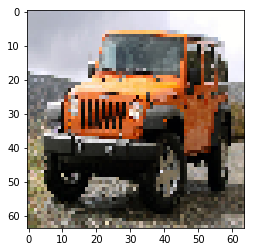

In [18]:
plt.imshow(X_train[0])

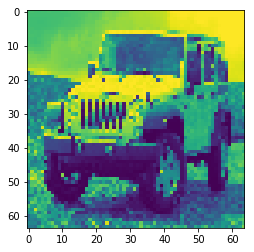

In [19]:
plt.imshow(X_train[0, :, :, 0])